In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd ~
%cd /content/drive/My\ Drive/
%mkdir WGAN_experiments
%cd WGAN_experiments

# If running in Google Colab, comment the above and uncomment the following:
# !git clone https://github.com/ghoshadi/WGAN_experiments.git
# %cd WGAN_experiments

/root
/content/drive/My Drive
mkdir: cannot create directory ‘WGAN_experiments’: File exists
/content/drive/My Drive/WGAN_experiments


In [3]:
!pip install git+https://github.com/gsbDBI/ds-wgan

  Cloning https://github.com/gsbDBI/ds-wgan to /tmp/pip-req-build-yf359386
  Running command git clone --filter=blob:none --quiet https://github.com/gsbDBI/ds-wgan /tmp/pip-req-build-yf359386
  Resolved https://github.com/gsbDBI/ds-wgan to commit ee7fa679dfda852cdb04cef211f2370599e657b6
  Preparing metadata (setup.py) ... done
  Created wheel for wgan: filename=wgan-0.2-py3-none-any.whl size=12203 sha256=9a4d6184cd0a7cb2858aba440661e0904f7477840c3f30e20e761b40f81683e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-kevkyaup/wheels/23/fb/53/3489b6543914454b4e6d7480ab82beba438d727d56f67c879b
Successfully built wgan


In [4]:
import os, pickle, random
import wgan
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
importlib.reload(wgan)

os.makedirs("artifacts", exist_ok=True)
os.makedirs("trained_models", exist_ok=True)
os.makedirs("fake_datasets", exist_ok=True)

USE_GPU = True  # set to True if you want to run on GPU

use_cuda = USE_GPU and torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

if use_cuda:
    torch.cuda.set_device(0)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

def set_all_seeds(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.benchmark = False

set_all_seeds(0)
nreps = None
n_oracle = 10_000_000

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


## Helper functions

In [5]:
class RandomizedECDF:
    """
    Randomized ranks using the normalization 1/(n+1).
    Forward:
        u = F_{n+1}(X-) + W * P_{n+1}(X),  W ~ Unif(0,1)
        z = Phi^{-1}(u)  (Gaussian ranks; default)
    Inverse:
        input_type='gaussian': map z -> u = Phi(z) -> X via right-continuous quantile
        input_type='uniform' : map u -> X via right-continuous quantile
    """
    def __init__(self, clip_eps: float = 1e-12):
        self.vals_ = None
        self.counts_ = None
        self.cum_ = None          # right-continuous CDF @ support, with denom (n+1)
        self.cum_left_ = None     # left limits F(x-), denom (n+1)
        self.n_ = None
        self.map_ = None          # value: (F(x-), F(x)) with denom (n+1)
        self.clip_eps = clip_eps
        self._std_norm = torch.distributions.Normal(loc=torch.tensor(0.0, dtype=torch.float64),
                                                    scale=torch.tensor(1.0, dtype=torch.float64))

    def fit(self, x: np.ndarray):
        x = np.asarray(x)
        vals, counts = np.unique(x, return_counts=True)
        n = counts.sum()
        denom = float(n + 1)  # 1/(n+1)

        cum_counts = np.cumsum(counts)
        cum = cum_counts / denom
        cum_left = (cum_counts - counts) / denom

        self.vals_ = vals
        self.counts_ = counts
        self.cum_ = cum
        self.cum_left_ = cum_left
        self.n_ = n
        self.map_ = dict(zip(vals, zip(cum_left, cum)))

    def transform(self, x: np.ndarray, rng: np.random.Generator = None, return_type: str = "gaussian") -> np.ndarray:
        """
        return_type='gaussian' -> Gaussian ranks z = Phi^{-1}(u)  [default]
        return_type='uniform'  -> randomized uniform ranks u in (0,1)
        """
        assert self.map_ is not None

        if rng is None:
          rand_fn = np.random.random
        else:
          rand_fn = rng.random

        x = np.asarray(x)
        lo_hi = np.array([self.map_[xi] for xi in x], dtype=float)  # (n,2)
        lo = lo_hi[:, 0]; hi = lo_hi[:, 1]
        u = lo + (hi - lo) * rand_fn(size=x.shape[0])

        if return_type == "uniform":
            return u

        # Gaussian ranks
        u = np.clip(u, self.clip_eps, 1.0 - self.clip_eps)
        z = self._std_norm.icdf(torch.from_numpy(u).to(torch.float64)).numpy()
        return z

    def cdf_left(self, t: float) -> float:
        """
        F(t-) = P(X < t) using denom (n+1).
        """
        idx = np.searchsorted(self.vals_, t, side='left')  # first index >= t
        if idx == 0:
            return 0.0
        return self.cum_[idx - 1]  # equals cum_left at t if t is in support

    def inverse(self, arr: np.ndarray, input_type: str = "gaussian") -> np.ndarray:
        """
        input_type='gaussian': arr = z, map via u = Phi(z) then quantile
        input_type='uniform' : arr = u in (0,1), map directly via quantile
        """
        if input_type == "gaussian":
            z = torch.as_tensor(arr, dtype=torch.float64)
            u = self._std_norm.cdf(z).numpy()
        elif input_type == "uniform":
            u = np.asarray(arr, dtype=float)
        else:
            raise ValueError("input_type must be 'gaussian' or 'uniform'")

        # right-continuous quantile: smallest x with F(x) >= u
        idx = np.searchsorted(self.cum_, u, side='left')
        idx = np.clip(idx, 0, len(self.vals_) - 1)
        return self.vals_[idx]

    def save(self, path: str):
        with open(path, "wb") as f:
            pickle.dump(
                dict(vals=self.vals_, counts=self.counts_, cum=self.cum_,
                     cum_left=self.cum_left_, n=self.n_, clip_eps=self.clip_eps), f
            )

    @classmethod
    def load(cls, path: str):
        with open(path, "rb") as f:
            d = pickle.load(f)
        obj = cls(clip_eps=d.get("clip_eps", 1e-12))
        obj.vals_ = d["vals"]; obj.counts_ = d["counts"]; obj.cum_ = d["cum"]
        obj.cum_left_ = d["cum_left"]; obj.n_ = d["n"]
        obj.map_ = dict(zip(obj.vals_, zip(obj.cum_left_, obj.cum_)))
        return obj

In [6]:
# --------- save models ---------
def save_models(tag: str):
    names = [("Gva", gen_va), ("Cva", crit_va),
             ("Gvb", gen_vb), ("Cvb", crit_vb)]
    for nm, m in names:
        torch.save(m.state_dict(), f"trained_models/{nm}_{tag}.pth")

# --------- load trained models ---------
def load_models(tag: str):
    gen_va.load_state_dict(torch.load(f"trained_models/Gva_{tag}.pth"))
    crit_va.load_state_dict(torch.load(f"trained_models/Cva_{tag}.pth"))
    gen_vb.load_state_dict(torch.load(f"trained_models/Gvb_{tag}.pth"))
    crit_vb.load_state_dict(torch.load(f"trained_models/Cvb_{tag}.pth"))

## Lee data

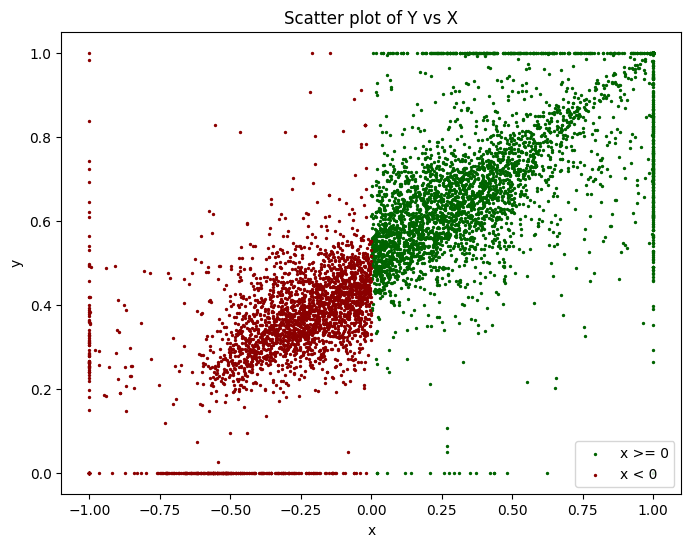

-0.2076615837932804

In [7]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/Lee.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/Lee_Fx.pkl")
# Fy.save("artifacts/Lee_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/Lee_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Lee_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [8]:
# --------- prepare splits ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 256
g_lr = 5e-5
c_lr = 1e-4
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 2501

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'dev

In [9]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("Lee")

In [10]:
load_models("Lee")

In [11]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/Lee_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Lee_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

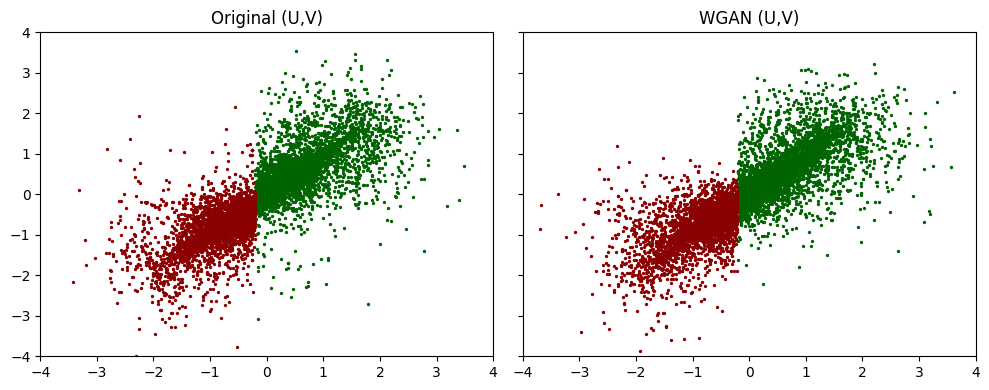

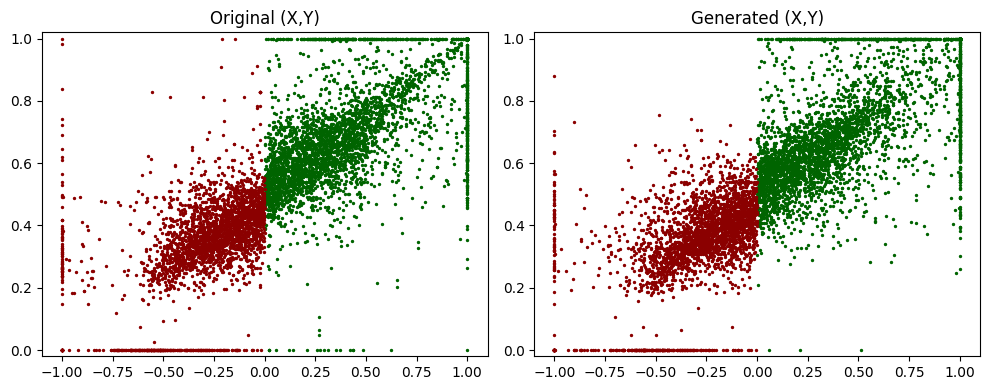

In [12]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/Lee_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/Lee_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_Lee = cate_at_threshold(n_oracle)
ground_truth_Lee

0.10204229314605973

In [14]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_Lee", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
      return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_Lee/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Senate data

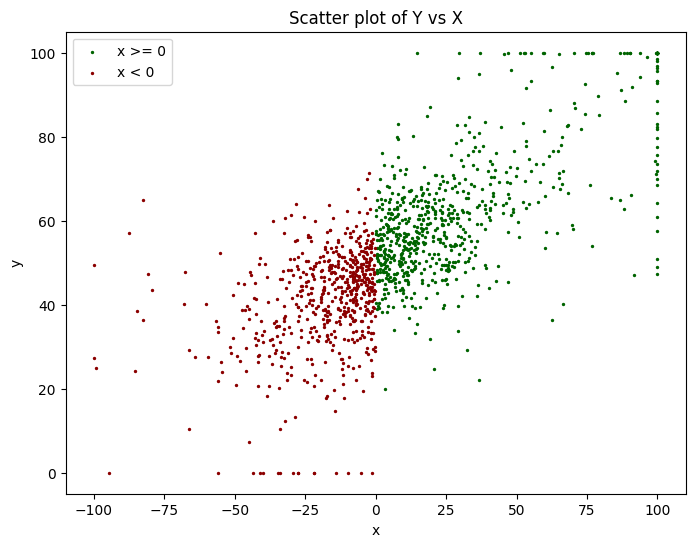

-0.10447164474747381

In [15]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/senate.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/senate_Fx.pkl")
# Fy.save("artifacts/senate_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/senate_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/senate_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [16]:
# --------- prepare splits and bounds in [0,1] ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 256
g_lr = 5e-5
c_lr = 1e-4
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 2001

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2001, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2001, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'dev

In [17]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("senate")

In [18]:
load_models("senate")

In [19]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/senate_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/senate_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

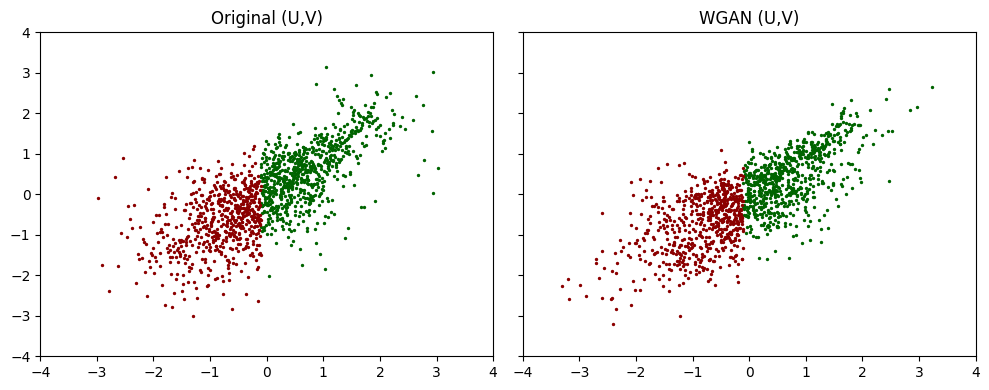

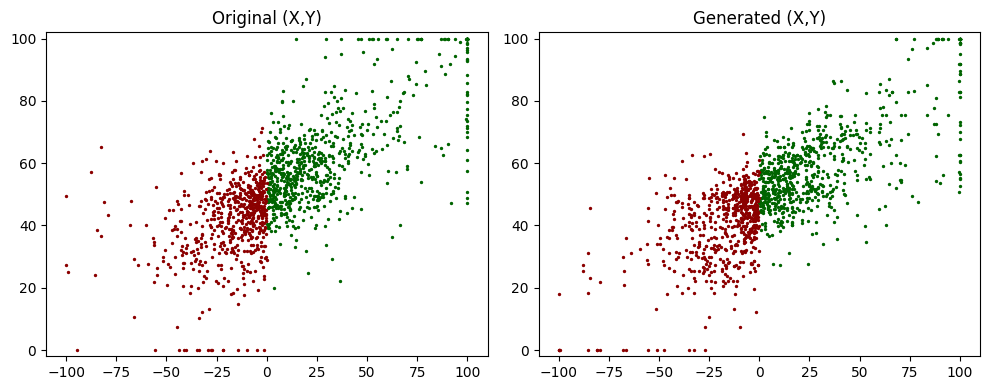

In [20]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/senate_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/senate_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_senate = cate_at_threshold(n_oracle)
ground_truth_senate

5.606050811822797

In [22]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_senate", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
      return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_senate/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Ludwig-Miller

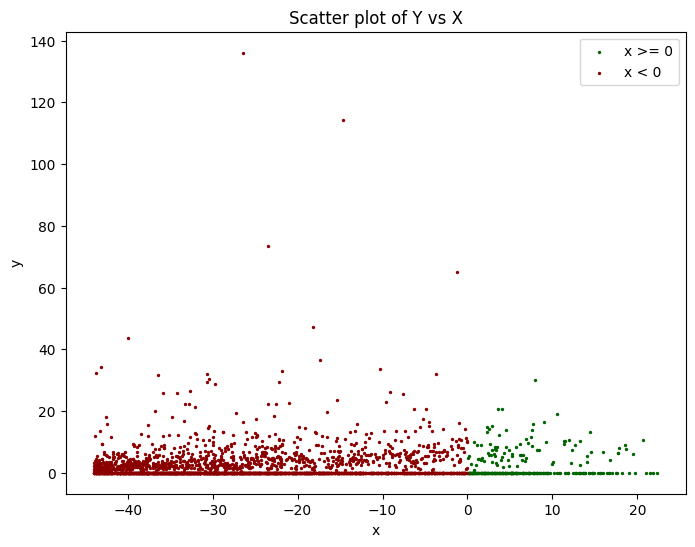

1.2482888735390092

In [23]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/LudMill.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/LudMill_Fx.pkl")
# Fy.save("artifacts/LudMill_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/LudMill_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/LudMill_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [24]:
# --------- prepare splits and bounds in [0,1] ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 256
g_lr = 5e-5
c_lr = 1e-4
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 2501

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'dev

In [25]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("LudMill")

In [26]:
load_models("LudMill")

In [27]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/LudMill_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/LudMill_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

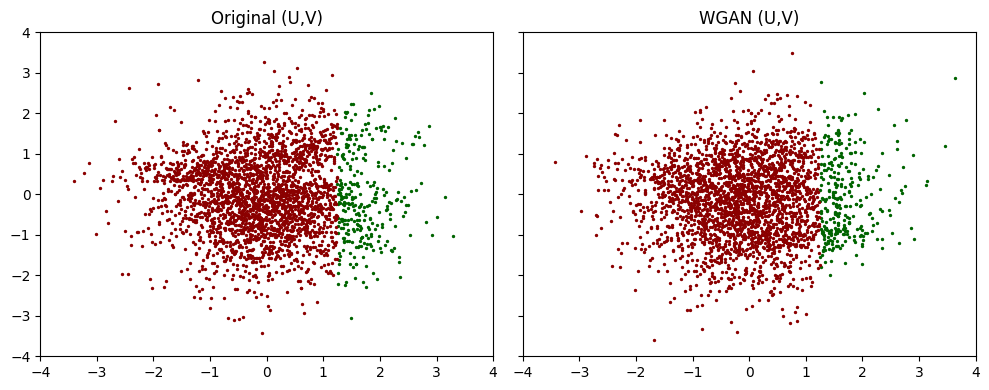

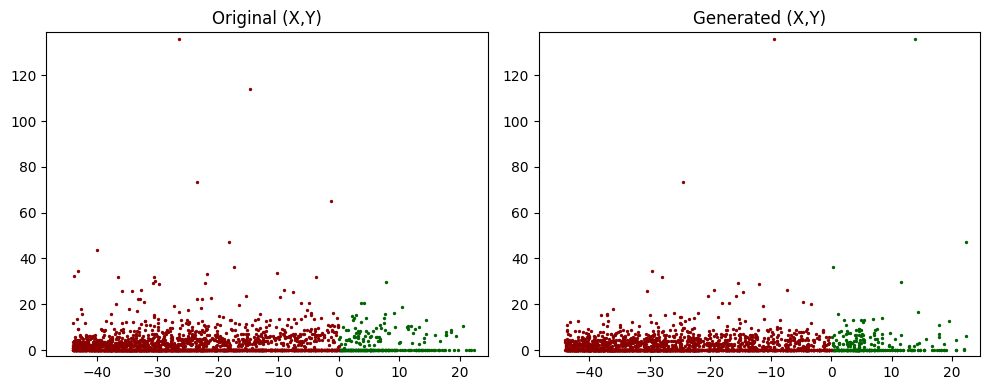

In [28]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [29]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/LudMill_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/LudMill_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_LudMill = cate_at_threshold(n_oracle)
ground_truth_LudMill

0.03107458649389727

In [30]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_LudMill", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
      return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_LudMill/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Meyersson data

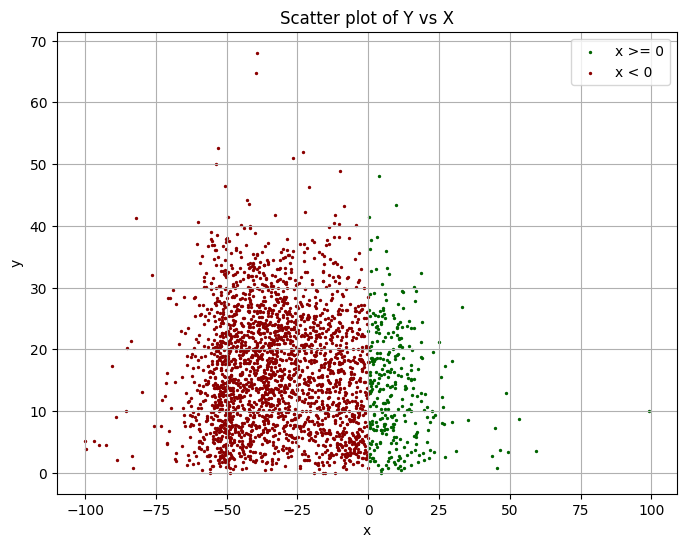

1.1742268290229316

In [31]:
# --------- load data ---------
# df must have columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/Meyersson.csv")
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/Meyersson_Fx.pkl")
# Fy.save("artifacts/Meyersson_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/Meyersson_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Meyersson_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.grid(True)
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [32]:
# --------- prepare splits and bounds in [0,1] ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 128
g_lr = 5e-5
c_lr = 1e-4
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 6 # critic gp factor
steps = 10 # critic steps
epochs = 2501

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 6, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 128, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0001, 'critic_gp_factor': 6, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 5e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 128, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'dev

In [33]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("Meyersson_dec")

In [34]:
load_models("Meyersson")

In [35]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/Meyersson_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Meyersson_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

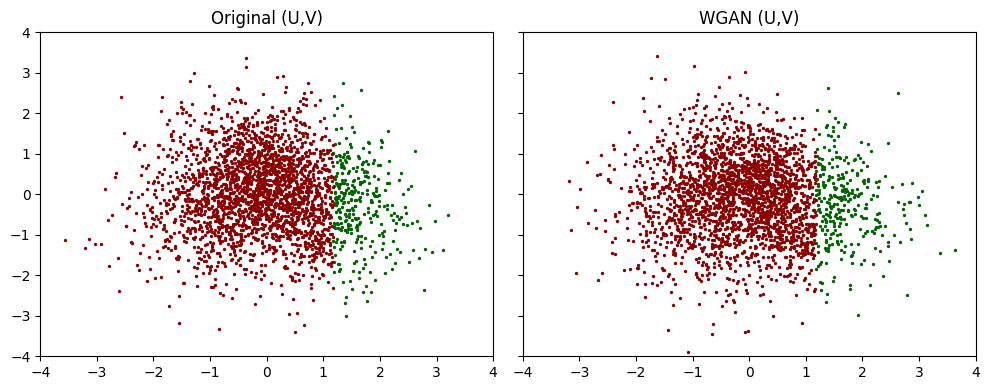

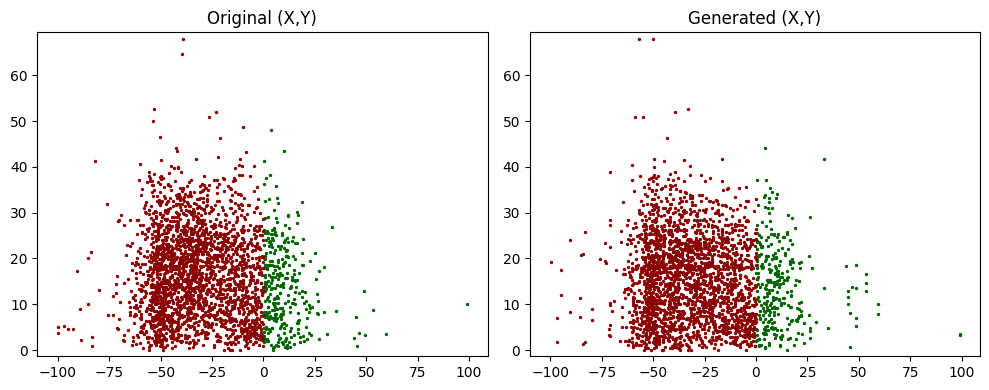

In [36]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/Meyersson_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/Meyersson_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_Meyersson = cate_at_threshold(n_oracle)
ground_truth_Meyersson

3.133590715637059

In [38]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_Meyersson", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
      return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_Meyersson/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Jacob-Lefgren reading

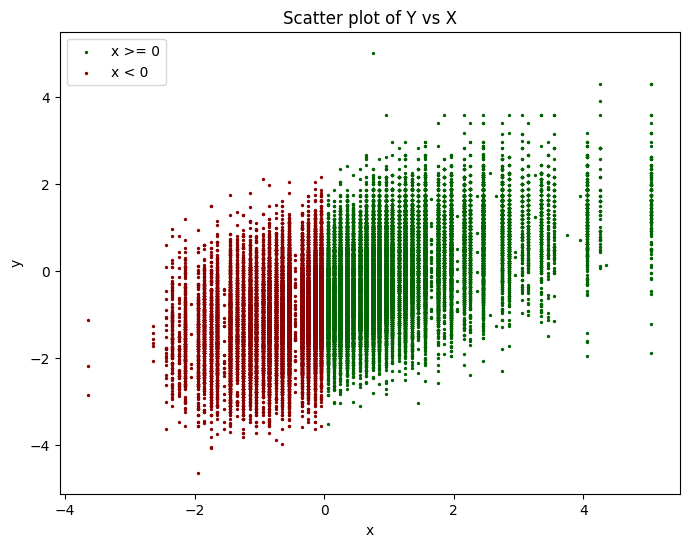

-0.30856570930833777

In [39]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/JL_read.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/JL_read_Fx.pkl")
# Fy.save("artifacts/JL_read_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/JL_read_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/JL_read_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [40]:
# --------- prepare splits ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] <  c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# --------- data wrappers ---------
# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 2048
g_lr = 1e-5
c_lr = 2e-5
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 15 # critic steps
epochs = 1001

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 2e-05, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 1e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 2e-05, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 1e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'dev

In [41]:
load_models("JL_read")

In [42]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/JL_read_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/JL_read_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

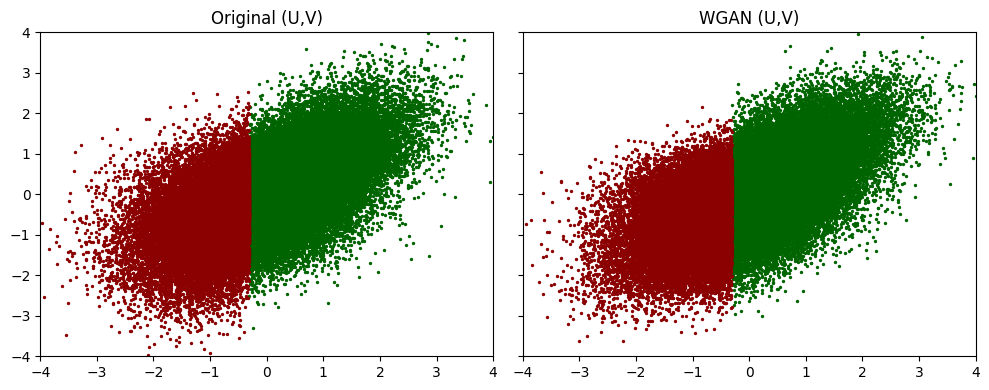

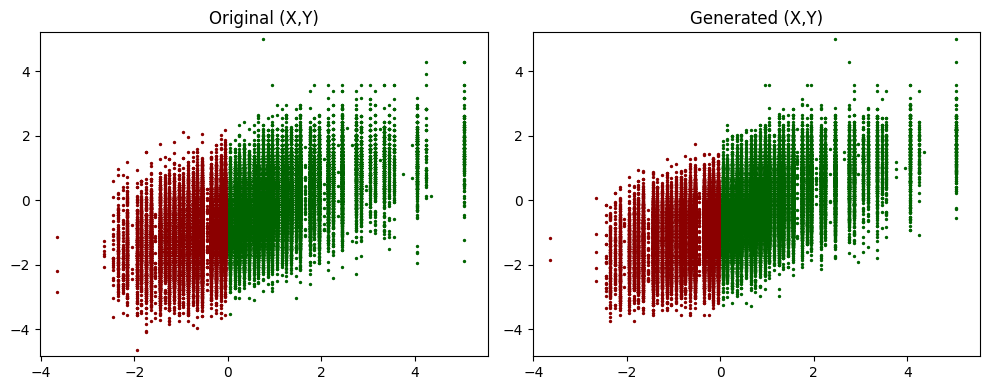

In [43]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/JL_read_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/JL_read_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_JL_read = cate_at_threshold(n_oracle)
ground_truth_JL_read

-0.03687706021999959

In [45]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_JL_read", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
    return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_JL_read/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Jacob-Lefgren math

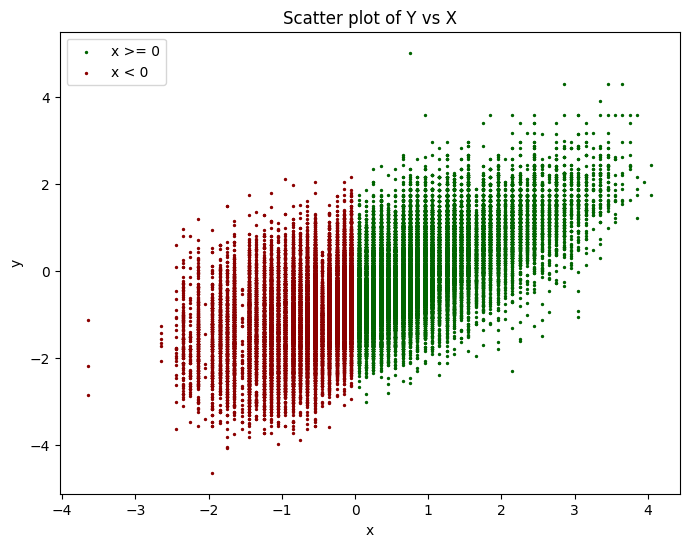

-0.1964586609514486

In [46]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/JL_math.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/JL_math_Fx.pkl")
# Fy.save("artifacts/JL_math_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/JL_math_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/JL_math_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [47]:
# --------- prepare splits ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 2048
g_lr = 1e-4
c_lr = 2e-4
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 1001

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0002, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0002, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 

In [48]:
load_models("JL_math")

In [49]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/JL_math_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/JL_math_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

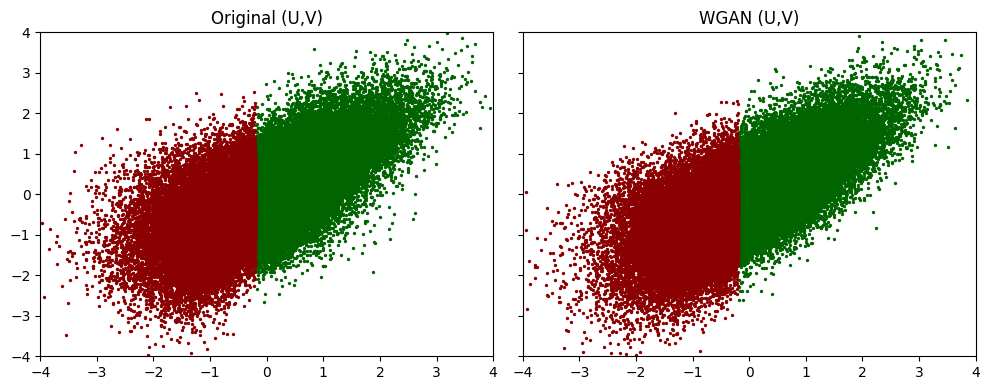

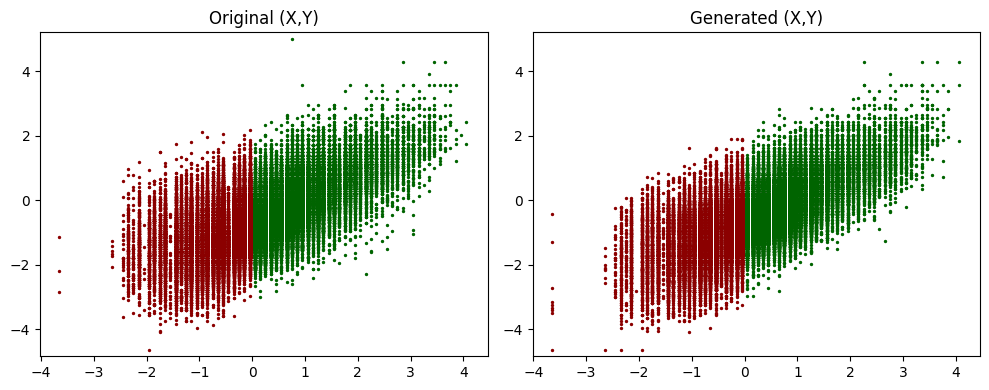

In [50]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [51]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/JL_math_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/JL_math_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_JL_math = cate_at_threshold()
ground_truth_JL_math

0.05868044999999944

In [52]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_JL_math", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
    return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_JL_math/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Matsudaira reading

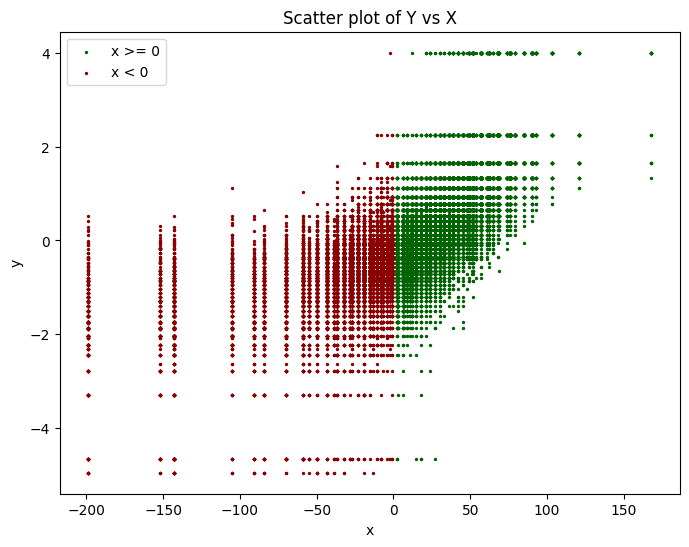

-0.43236687571133603

In [53]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/Mats_read.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/Mats_read_Fx.pkl")
# Fy.save("artifacts/Mats_read_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/Mats_read_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Mats_read_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [54]:
# --------- prepare splits and bounds in [0,1] ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] <  c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# --------- data wrappers ---------
# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 2048
g_lr = 2e-5
c_lr = 5e-5
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 1001

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 5e-05, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 2e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 5e-05, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 2e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'dev

In [55]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("Mats_read")

In [56]:
load_models("Mats_read")

In [57]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/Mats_read_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Mats_read_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

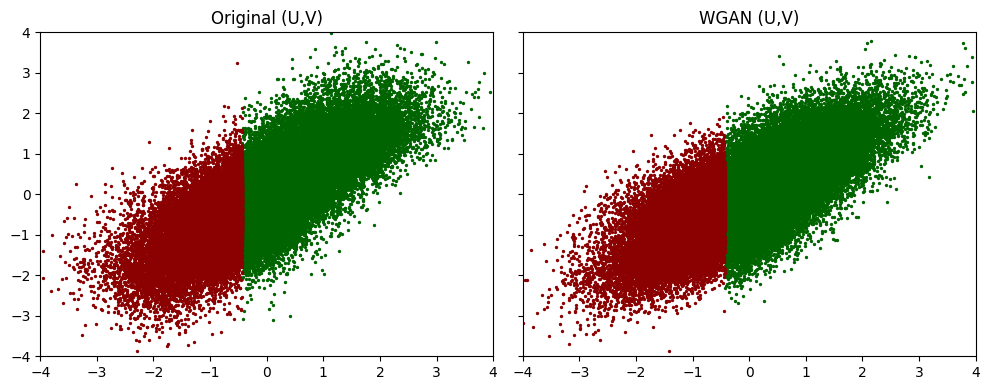

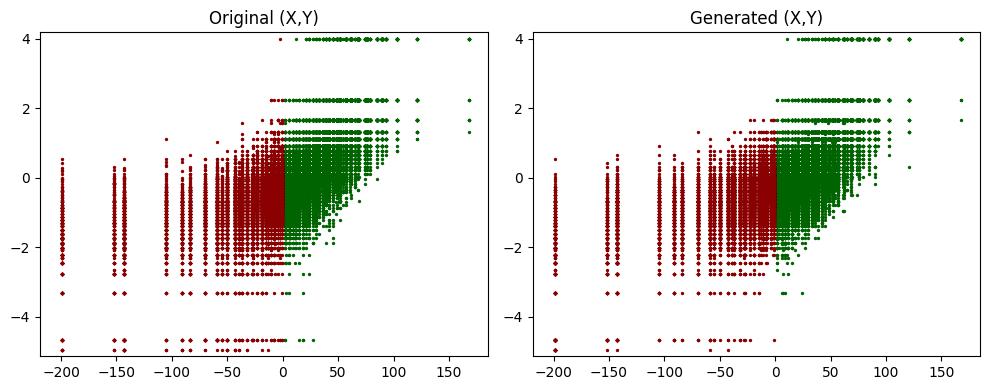

In [58]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [59]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/Mats_read_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/Mats_read_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_Mats_read = cate_at_threshold(n_oracle)
ground_truth_Mats_read

-0.16772141697083925

In [60]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_Mats_read", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
      return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_Mats_read/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Matsudaira math

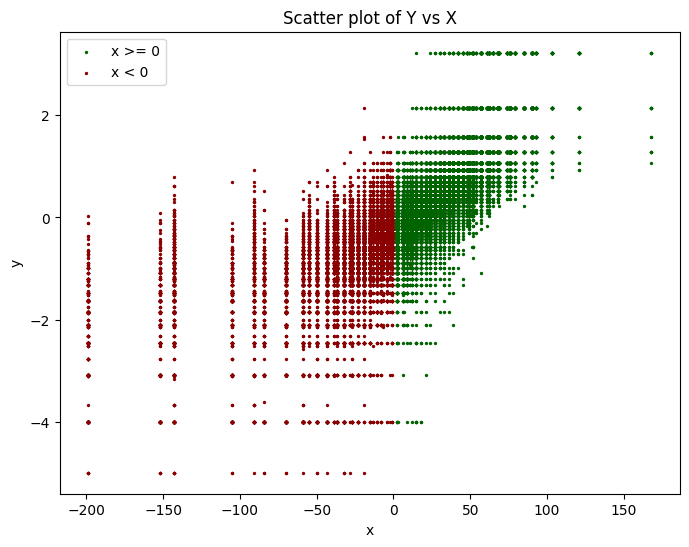

-0.43236687571133603

In [61]:
# --------- load data ---------
# df must have discrete columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/Mats_math.csv")  # replace with your file
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/Mats_math_Fx.pkl")
# Fy.save("artifacts/Mats_math_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/Mats_math_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Mats_math_Fy.pkl")

U = Fx.transform(x)  # N(0,1)
V = Fy.transform(y)  # N(0,1)

df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [62]:
# --------- prepare splits and bounds in [0,1] ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 2048
g_lr = 1e-4
c_lr = 2e-4
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 1001

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=100
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0002, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 0.0002, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 1001, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 

In [63]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("Mats_math")

In [64]:
load_models("Mats_math")

In [65]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/Mats_math_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Mats_math_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_uv = sample_uv_like(df_uv)
syn_xy = uv_to_xy(syn_uv)

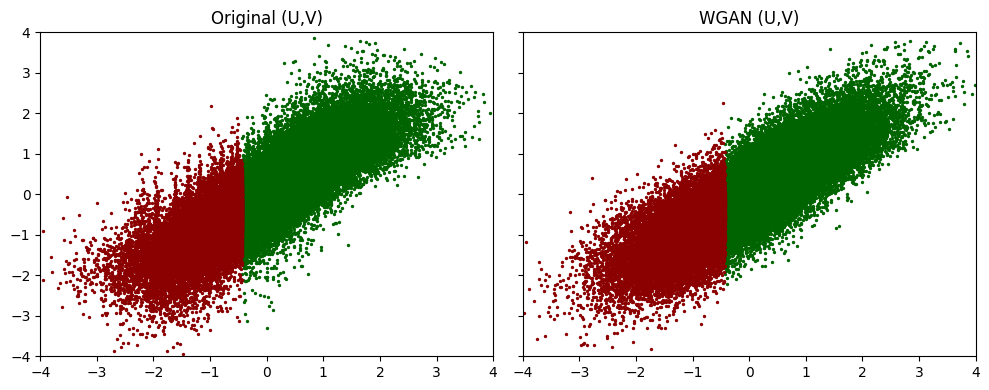

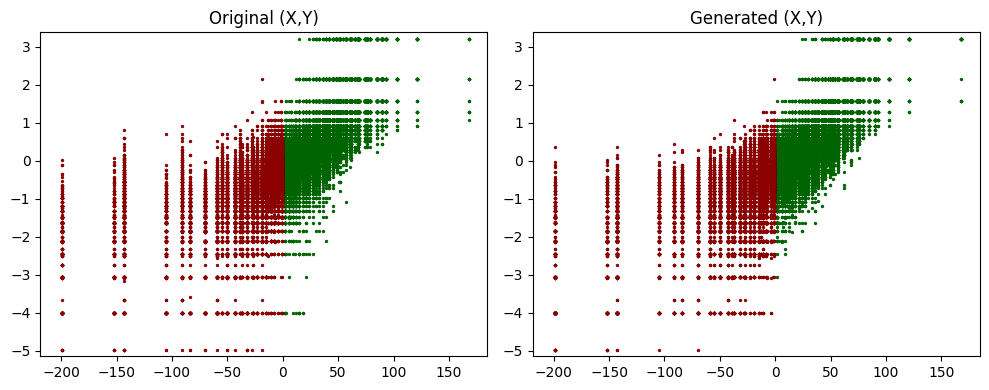

In [66]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [67]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/Mats_math_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/Mats_math_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_Mats_math = cate_at_threshold(n_oracle)
ground_truth_Mats_math

0.0653581627113804

In [68]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_Mats_math", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
      return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_Mats_math/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Oreopoulos

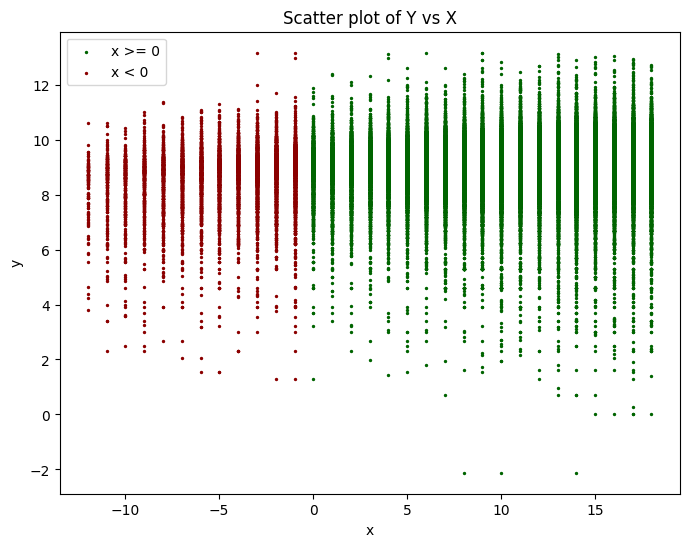

-1.1863235306973783

In [69]:
# --------- load data ---------
# df must have columns 'x' and 'y'
df = pd.read_csv("./cleaned_datasets/Oreopoulos.csv")
assert {"x","y"}.issubset(df.columns)

x = df["x"].to_numpy()
y = df["y"].to_numpy()

## --------- fit transforms and map to (U,V) ---------
# set_all_seeds(0)
# Fx = RandomizedECDF(); Fx.fit(x)
# Fy = RandomizedECDF(); Fy.fit(y)
# Fx.save("artifacts/Oreopoulos_Fx.pkl")
# Fy.save("artifacts/Oreopoulos_Fy.pkl")

Fx = RandomizedECDF.load("artifacts/Oreopoulos_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Oreopoulos_Fy.pkl")
U = Fx.transform(x)
V = Fy.transform(y)
df_uv = pd.DataFrame({"u": U, "v": V})

# --------- scatterplot of data ---------
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["x"] >= 0, "x"], df.loc[df["x"] >= 0, "y"], s=2, c="darkgreen", label="x >= 0")
plt.scatter(df.loc[df["x"] < 0, "x"], df.loc[df["x"] < 0, "y"], s=2, c="darkred", label="x < 0")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of Y vs X")
plt.legend()
plt.show()

# cutoff c = F_X(0-)
c_prob = Fx.cdf_left(0.0) # in (0,1)
c = torch.distributions.Normal(0,1).icdf(torch.tensor(c_prob)).item()  # map to z
c

In [70]:
# --------- prepare splits ---------
dfa = df_uv[df_uv["u"] >= c].copy()
dfb = df_uv[df_uv["u"] < c].copy()

lbound_v = {"v": -5.0}; ubound_v = {"v": 5.0}

# V | U >= c
dw_va = wgan.DataWrapper(dfa, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_va, ctx_va = dw_va.preprocess(dfa)

# V | U < c
dw_vb = wgan.DataWrapper(dfb, ["v"], context_vars=["u"],
                         continuous_lower_bounds=lbound_v,
                         continuous_upper_bounds=ubound_v)
x_vb, ctx_vb = dw_vb.preprocess(dfb)

def to_cuda(t):
    if t is None:
        return None
    if torch.is_tensor(t):
        return t.to(device, non_blocking=True)
    return torch.as_tensor(t, device=device)

# --------- WGAN specs ---------
bsize = 2048
g_lr = 4e-5
c_lr = 8e-5
cd = [128, 128, 128]
gd = [128, 128, 128]
noise = 4
dropout = 0.1
factor = 5 # critic gp factor
steps = 10 # critic steps
epochs = 2501

spec_va = wgan.Specifications(
    dw_va,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

spec_vb = wgan.Specifications(
    dw_vb,
    batch_size=bsize,
    max_epochs=epochs,
    optimizer=torch.optim.Adam,
    generator_optimizer=wgan.OAdam,
    critic_lr=c_lr,
    generator_lr=g_lr,
    generator_d_noise=noise,
    critic_d_hidden=cd,
    generator_d_hidden=gd,
    critic_gp_factor=factor,
    generator_dropout=dropout,
    critic_steps=steps,
    print_every=200
)

gen_va = wgan.Generator(spec_va);  crit_va = wgan.Critic(spec_va)
gen_vb = wgan.Generator(spec_vb);  crit_vb = wgan.Critic(spec_vb)

for m in [gen_va, crit_va, gen_vb, crit_vb]:
    m.to(device)

x_va    = x_va.to(device, non_blocking=True)
ctx_va  = None if ctx_va is None else ctx_va.to(device, non_blocking=True)

x_vb    = x_vb.to(device, non_blocking=True)
ctx_vb  = None if ctx_vb is None else ctx_vb.to(device, non_blocking=True)

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 8e-05, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 4e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 10, 'critic_lr': 8e-05, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 4e-05, 'generator_d_noise': 4, 'generator_optimizer': <class 'wgan.wgan.OAdam'>, 'max_epochs': 2501, 'batch_size': 2048, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 200, 'dev

In [71]:
# # --------- train ---------
# wgan.train(gen_va, crit_va, x_va, ctx_va, spec_va)
# wgan.train(gen_vb, crit_vb, x_vb, ctx_vb, spec_vb)
# save_models("Oreopoulos")

In [72]:
load_models("Oreopoulos")

In [73]:
# --------- generate a synthetic (U,V) sample from trained models ---------
def sample_uv_like(df_ref: pd.DataFrame, n: int = None) -> pd.DataFrame:
    """
    1) Sample U from its marginal WGAN.
    2) Route each U to conditional generator. Use Gva if u>=c, else Gvb.
    """
    if n is None: n = len(df_ref)
    # step 1: sample U from N(0,1)
    rng = np.random.default_rng()
    u = rng.standard_normal(n, dtype=np.float32)

    # step 2: conditionals
    df_u = pd.DataFrame({"u": u})
    va_in = df_u[df_u["u"] >= c].copy()
    vb_in = df_u[df_u["u"] < c].copy()

    out_parts = []
    if len(va_in):
        tmp = dw_va.apply_generator(gen_va, va_in)
        out_parts.append(tmp[["u","v"]])
    if len(vb_in):
        tmp = dw_vb.apply_generator(gen_vb, vb_in)
        out_parts.append(tmp[["u","v"]])
    out = pd.concat(out_parts, axis=0, ignore_index=True)
    return out

syn_uv = sample_uv_like(df_uv)

# --------- inverse map to (X,Y) ---------
Fx = RandomizedECDF.load("artifacts/Oreopoulos_Fx.pkl")
Fy = RandomizedECDF.load("artifacts/Oreopoulos_Fy.pkl")

def uv_to_xy(df_uv_in: pd.DataFrame) -> pd.DataFrame:
    u = df_uv_in["u"].to_numpy()
    v = df_uv_in["v"].to_numpy()
    #x_back = Fx.inverse(u, input_type="uniform")
    #y_back = Fy.inverse(v, input_type="uniform")
    x_back = Fx.inverse(u, input_type="gaussian")
    y_back = Fy.inverse(v, input_type="gaussian")
    return pd.DataFrame({"x": x_back, "y": y_back})

syn_xy = uv_to_xy(syn_uv)

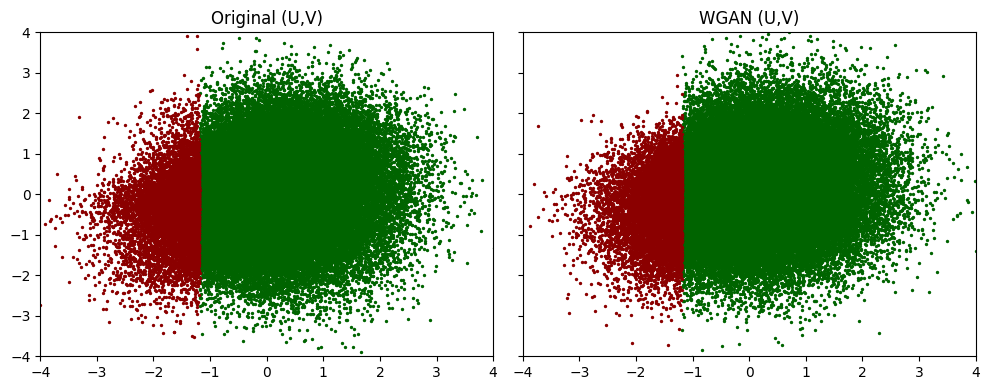

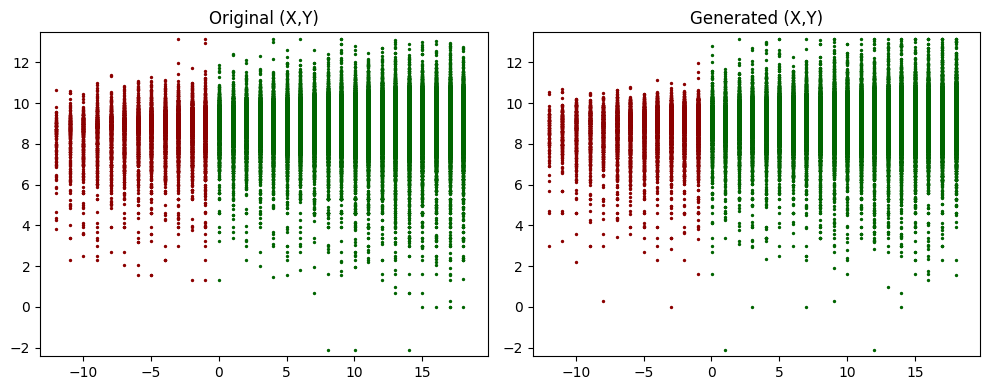

In [74]:
# --------- side-by-side plots (U,V) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
# original
axes[0].scatter(df_uv.loc[df_uv["u"]>=c,"u"], df_uv.loc[df_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[0].scatter(df_uv.loc[df_uv["u"]< c,"u"], df_uv.loc[df_uv["u"]< c,"v"], s=2, c="darkred")
axes[0].set_title("Original (U,V)")

# synthetic
axes[1].scatter(syn_uv.loc[syn_uv["u"]>=c,"u"], syn_uv.loc[syn_uv["u"]>=c,"v"], s=2, c="darkgreen")
axes[1].scatter(syn_uv.loc[syn_uv["u"]< c,"u"], syn_uv.loc[syn_uv["u"]< c,"v"], s=2, c="darkred")
axes[1].set_title("WGAN (U,V)")
for ax in axes:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
plt.tight_layout(); plt.show()

# --------- side-by-side (X,Y) ---------
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

axes[0].scatter(df.loc[df["x"]>=0,"x"], df.loc[df["x"]>=0,"y"], s=2, c="darkgreen")
axes[0].scatter(df.loc[df["x"]< 0,"x"], df.loc[df["x"]< 0,"y"], s=2, c="darkred")
axes[0].set_title("Original (X,Y)")

axes[1].scatter(syn_xy.loc[syn_xy["x"]>=0,"x"], syn_xy.loc[syn_xy["x"]>=0,"y"], s=2, c="darkgreen")
axes[1].scatter(syn_xy.loc[syn_xy["x"]< 0,"x"], syn_xy.loc[syn_xy["x"]< 0,"y"], s=2, c="darkred")
axes[1].set_title("Generated (X,Y)")

x_min, x_max = 1.1*df["x"].min(), 1.1*df["x"].max()
y_min, y_max = df["y"].min()-(df["y"].max()-df["y"].min())/50, df["y"].max()+(df["y"].max()-df["y"].min())/50
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout(); plt.show()

In [75]:
import numpy as np
import pandas as pd
from scipy.stats import norm

set_all_seeds(0)

def _cdf_left_right_at_zero(Fx_local):
    p_L = Fx_local.cdf_left(0.0)
    idx0 = np.searchsorted(Fx_local.vals_, 0.0, side='right') - 1
    p_R = Fx_local.cum_[idx0] if (idx0 >= 0 and Fx_local.vals_[idx0] <= 0.0) else p_L
    return float(p_L), float(p_R)

def cate_at_threshold(n=1_000_000, eps=1e-12, seed=42):
    """
    Estimate E[Y|X=0+] - E[Y|X=0-] by conditioning the two V|U GANs
    at one-sided points on the probability scale, mapped to Gaussian via Phi^{-1}.
    """
    set_all_seeds(seed)

    Fx = RandomizedECDF.load("artifacts/Oreopoulos_Fx.pkl")
    Fy = RandomizedECDF.load("artifacts/Oreopoulos_Fy.pkl")

    p_L, p_R = _cdf_left_right_at_zero(Fx)

    # one-sided probabilities; clip away from 0/1 to avoid infinities
    p_right = min(p_R, 1.0 - eps)
    p_left  = max(p_L, eps)

    # map to the training scale for the conditional GANs
    u_right = norm.ppf(p_right)
    u_left  = norm.ppf(p_left)

    # build inputs (constant U per side)
    df_ur = pd.DataFrame({"u": np.full(n, u_right)})
    df_ul = pd.DataFrame({"u": np.full(n, u_left)})

    # generate V on Gaussian scale from each arm's conditional WGAN
    v_right = dw_va.apply_generator(gen_va, df_ur)[["v"]].to_numpy().ravel()
    v_left  = dw_vb.apply_generator(gen_vb, df_ul)[["v"]].to_numpy().ravel()

    # invert V -> Y using Gaussian input_type
    y_right = Fy.inverse(v_right, input_type="gaussian")
    y_left  = Fy.inverse(v_left,  input_type="gaussian")

    return float(np.mean(y_right) - np.mean(y_left))

torch.manual_seed(0); np.random.seed(0)
ground_truth_Oreopoulos = cate_at_threshold(n_oracle)
ground_truth_Oreopoulos

0.06999779514498172

In [76]:
if nreps is not None and nreps > 0:
  set_all_seeds(0)
  os.makedirs("fake_datasets/wgan_Oreopoulos", exist_ok=True)

  # --------- replicate datasets ---------
  def generate_synthetic_dataset_like(df_ref: pd.DataFrame) -> pd.DataFrame:
    return uv_to_xy(sample_uv_like(df_ref, n=len(df_ref)))

  for i in range(nreps):
    if (i+1) % (nreps/20) == 0:
        print(i+1)
    syn_xy_i = generate_synthetic_dataset_like(df)
    syn_xy_i.to_parquet(f"fake_datasets/wgan_Oreopoulos/df_{i+1}.parquet", index=False, compression="zstd")

set_all_seeds(0)

## Ground truths

In [77]:
data = {
    "Lee": ground_truth_Lee,
    "senate": ground_truth_senate,
    "LudMill": ground_truth_LudMill,
    "Meyersson": ground_truth_Meyersson,
    "Mats_read": ground_truth_Mats_read,
    "Mats_math": ground_truth_Mats_math,
    "JL_read": ground_truth_JL_read,
    "JL_math": ground_truth_JL_math,
    "Oreopoulos": ground_truth_Oreopoulos
}

for name, value in data.items():
    print(f"{name}: {value}")

df_ground_truths = pd.DataFrame.from_dict(data, orient='index', columns=['Ground Truth'])
df_ground_truths.index.name = 'Dataset'
df_ground_truths.to_csv("ground_truths.csv")

Lee: 0.10204229314605973
senate: 5.606050811822797
LudMill: 0.03107458649389727
Meyersson: 3.133590715637059
Mats_read: -0.16772141697083925
Mats_math: 0.0653581627113804
JL_read: -0.03687706021999959
JL_math: 0.05868044999999944
Oreopoulos: 0.06999779514498172


In [78]:
import math
round(math.log(n_oracle,10))
df_ground_truths.to_csv(f"ground_truths{round(math.log(n_oracle,10))}.csv")